In [8]:
import cv2
import imutils
import matplotlib.pyplot as plt
from os import listdir
import tensorflow as tf
import time
import numpy

from keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'cv2'

In [14]:
def augment_data(file_dir, n_generated_samples,save_to_dir):
 
  data_gen=tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.1, brightness_range=(0.3, 1.0),horizontal_flip=True, vertical_flip=True, fill_mode='nearest')
  for file_name in listdir(file_dir):
    image=cv2.imread(file_dir+"/"+file_name)
    image = image.reshape((1,)+image.shape)
    save_prefix='aug_'+file_name[:-4]
    i=0
    for batch in data_gen.flow(x=image, batch_size=1,save_to_dir=save_to_dir,save_prefix=save_prefix,save_format=".jpg"):
      i=i+1
      if i>n_generated_samples:
        break;

In [15]:
def  hms_string(sec_elapsed):
  h=int(sec_elapsed/(60*60))
  m=int((sec_elapsed%(60*60))/60)
  s=sec_elapsed%60
  return f"{h}:{m}:{round(s,1)}"

In [16]:
start_time=time.time()
augmented_data_path = 'augmented data/'
# augment data for the examples with label equal to 'yes' representing tumurous examples
augment_data(file_dir='brain_tumor_dataset/yes', n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
# augment data for the examples with label equal to 'no' representing non-tumurous examples
augment_data(file_dir='brain_tumor_dataset/no', n_generated_samples=9, save_to_dir=augmented_data_path+'no')
end_time=time.time()
execution_time=(end_time-start_time)
print(f"time_elapsed : {hms_string(execution_time)}")

KeyboardInterrupt: 

In [ ]:
def data_summary(main_path):
    
    yes_path = main_path+'yes'
    no_path = main_path+'no'
        
    # number of files (images) that are in the the folder named 'yes' that represent tumorous (positive) examples
    m_pos = len(listdir(yes_path))
    # number of files (images) that are in the the folder named 'no' that represent non-tumorous (negative) examples
    m_neg = len(listdir(no_path))
    # number of all examples
    m = (m_pos+m_neg)
    
    pos_prec = (m_pos* 100.0)/ m
    neg_prec = (m_neg* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {m_pos}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {m_neg}")

In [ ]:
data_summary(augmented_data_path)

Number of examples: 2064
Percentage of positive examples: 52.56782945736434%, number of pos examples: 1085
Percentage of negative examples: 47.43217054263566%, number of neg examples: 979


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

In [ ]:
def crop_brain_contour(image, plot=False): 
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
                    
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

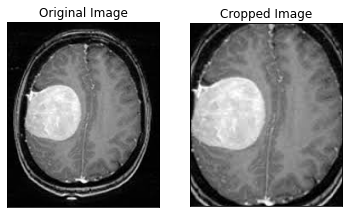

In [ ]:
ex_img = cv2.imread('brain_tumor_dataset/yes/Y1.jpg')
ex_new_img = crop_brain_contour(ex_img, True)

In [ ]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size
    
    for directory in dir_list:
        for filename in listdir(directory):
            # load the image
            image = cv2.imread(directory + '\\' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
                
    X = np.array(X)
    y = np.array(y)
        
    # Shuffle the data
    X, y = shuffle(X, y)
    
    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    
    return X, y

In [101]:
augmented_path = 'augmented data/'

# augmented data (yes and no) contains both the original and the new generated examples
augmented_yes = augmented_path + 'yes' 
augmented_no = augmented_path + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))

Number of examples is: 2612
X shape is: (2612, 240, 240, 3)
y shape is: (2612, 1)


In [ ]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            i += 1
            label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

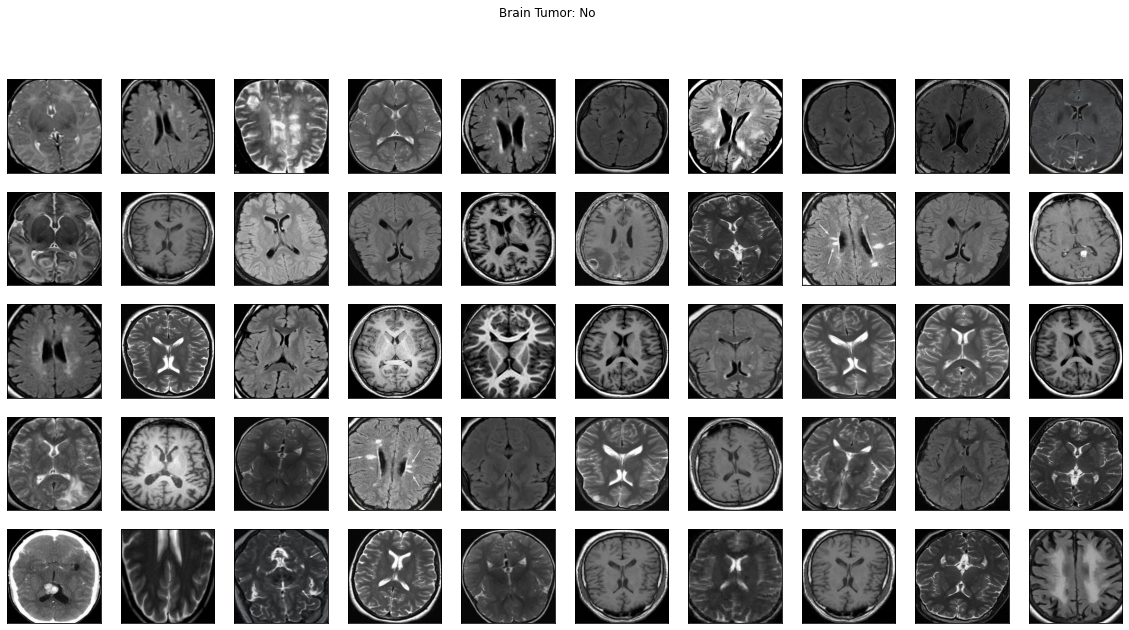

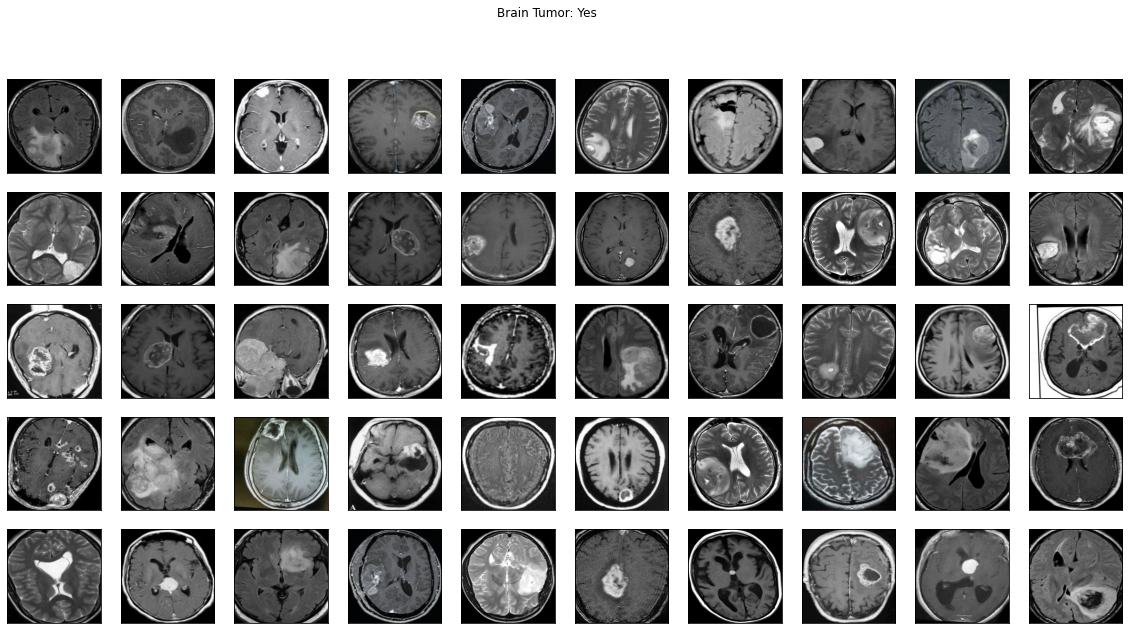

In [ ]:
plot_sample_images(X, y)


In [ ]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1444
number of development examples = 310
number of test examples = 310
X_train shape: (1444, 240, 240, 3)
Y_train shape: (1444, 1)
X_val (dev) shape: (310, 240, 240, 3)
Y_val (dev) shape: (310, 1)
X_test shape: (310, 240, 240, 3)
Y_test shape: (310, 1)


In [ ]:
vgg16=tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(240,240,3),pooling=max)

In [ ]:
VGG16=tf.keras.Sequential()
VGG16.add(vgg16)
VGG16.add(Dropout(0.3))
VGG16.add(Flatten())
VGG16.add(Dropout(0.5))
VGG16.add(Dense(1, activation='sigmoid'))
VGG16.layers[0].trainable = False
VGG16.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
VGG16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 512)         0         
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
checkpoint_path = "VGGmodels/{epoch:03d}-{val_accuracy:.2f}"#"models/{epoch:03d}-{val_loss:.2f}.h5"#"training_1/cp.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,monitor="val_accuracy", verbose=1, save_best_only=True, mode='auto',save_freq="epoch")

In [ ]:
start_time = time.time()

VGG16.fit(x=X_train, y=y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val),callbacks=[checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/25
46/46 [==============================] - 758s 16s/step - loss: 0.5701 - accuracy: 0.7036 - val_loss: 0.3537 - val_accuracy: 0.8645

Epoch 00001: val_accuracy improved from -inf to 0.86452, saving model to VGGmodels\001-0.86
INFO:tensorflow:Assets written to: VGGmodels\001-0.86\assets
Epoch 2/25
46/46 [==============================] - 797s 17s/step - loss: 0.2896 - accuracy: 0.8878 - val_loss: 0.2794 - val_accuracy: 0.9032

Epoch 00002: val_accuracy improved from 0.86452 to 0.90323, saving model to VGGmodels\002-0.90
INFO:tensorflow:Assets written to: VGGmodels\002-0.90\assets
Epoch 3/25
46/46 [==============================] - 812s 18s/step - loss: 0.2238 - accuracy: 0.9141 - val_loss: 0.2506 - val_accuracy: 0.8968

Epoch 00003: val_accuracy did not improve from 0.90323
Epoch 4/25
46/46 [==============================] - 1194s 26s/step - loss: 0.1823 - accuracy: 0.9363 - val_loss: 0.1898 - val_accuracy: 0.9452

Epoch 00004: val_accuracy improved from 0.90323 to 0.94516, sav

In [ ]:
bestincv3_model = load_model(filepath='VGGmodels/014-0.97')


In [ ]:
loss, acc = bestincv3_model.evaluate(x=X_test, y=y_test)


10/10 [==============================] - 87s 9s/step - loss: 0.0888 - accuracy: 0.9709


In [ ]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.08884237706661224
Test Accuracy = 0.9708737730979919


In [ ]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}")

In [ ]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 1445
Percentage of positive examples: 52.733564013840834%, number of pos examples: 762
Percentage of negative examples: 47.266435986159166%, number of neg examples: 683
Validation Data:
Number of examples: 310
Percentage of positive examples: 52.58064516129032%, number of pos examples: 163
Percentage of negative examples: 47.41935483870968%, number of neg examples: 147
Testing Data:
Number of examples: 310
Percentage of positive examples: 51.61290322580645%, number of pos examples: 160
Percentage of negative examples: 48.38709677419355%, number of neg examples: 150


In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [ ]:
def build_model(input_shape):
     # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')
    return model

In [ ]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
model = build_model(IMG_SHAPE)

In [ ]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 244, 244, 3)       0         
_________________________________________________________________
conv0 (Conv2D)               (None, 238, 238, 32)      4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 238, 238, 32)      128       
_________________________________________________________________
activation (Activation)      (None, 238, 238, 32)      0         
_________________________________________________________________
max_pool0 (MaxPooling2D)     (None, 59, 59, 32)        0         
_________________________________________________________________
max_pool1 (MaxPooling2D)     (None, 14, 14, 32)

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
46/46 [==============================] - 113s 2s/step - loss: 0.7422 - accuracy: 0.6526 - val_loss: 0.6470 - val_accuracy: 0.7129
Epoch 2/3
46/46 [==============================] - 102s 2s/step - loss: 0.4968 - accuracy: 0.7696 - val_loss: 0.5938 - val_accuracy: 0.7645
Epoch 3/3
46/46 [==============================] - 106s 2s/step - loss: 0.4076 - accuracy: 0.8263 - val_loss: 0.6219 - val_accuracy: 0.5903


In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val))

Epoch 1/3
46/46 [==============================] - 108s 2s/step - loss: 0.4079 - accuracy: 0.8118 - val_loss: 0.4820 - val_accuracy: 0.8194
Epoch 2/3
46/46 [==============================] - 107s 2s/step - loss: 0.3545 - accuracy: 0.8415 - val_loss: 0.4925 - val_accuracy: 0.7871
Epoch 3/3
46/46 [==============================] - 105s 2s/step - loss: 0.3454 - accuracy: 0.8505 - val_loss: 0.5455 - val_accuracy: 0.7065


In [ ]:
model.save('predict.h5')

In [ ]:
from tensorflow.keras.models import load_model
model=load_model('predict.h5')

from skimage.transform import resize
import cv2

In [ ]:
def detect(frame):
    img=resize(frame,(IMG_WIDTH,IMG_HEIGHT))
    img=np.expand_dims(img,axis=0)
    if(np.max(img))>1:
        img=img/255.0
    prediction=model.predict(img)
    print(prediction)
    if prediction>0.5:
        print('Yes')
    else:
        print('No')

In [ ]:
frame=cv2.imread('brain_tumor_dataset/no/1 no.jpeg')
data=detect(frame)

[[0.32111365]]
No


In [ ]:
frame=cv2.imread('brain_tumor_dataset/no/3 no.jpg')
data=detect(frame)

[[0.1029889]]
No


In [ ]:
frame=cv2.imread('brain_tumor_dataset/no/6 no.jpg')
data=detect(frame)

[[0.21225819]]
No


In [ ]:
frame=cv2.imread('brain_tumor_dataset/yes/Y6.jpg')
data=detect(frame)

[[0.3873696]]
No


In [7]:
from __future__ import division, print_function
# coding=utf-8
import sys
import os
import glob
import numpy as np
from tensorflow.keras.preprocessing import image 



from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions


from tensorflow.keras import backend

import tensorflow as tf

ModuleNotFoundError: No module named 'numpy'

In [ ]:

from skimage.transform import resize

# Flask utils
from flask import Flask, redirect, url_for, request, render_template
from werkzeug.utils import secure_filename
from gevent.pywsgi import WSGIServer

In [ ]:
app = Flask(__name__)

In [ ]:
MODEL_PATH = 'predict.h5'
model = load_model(MODEL_PATH)

In [ ]:
print('Model loaded. Check http://127.0.0.1:5000/')

Model loaded. Check http://127.0.0.1:5000/


In [ ]:
app = Flask(__name__)
MODEL_PATH = 'predict.h5'
model = load_model(MODEL_PATH)
@app.route('/', methods=['GET'])
def index():
    # Main page
    return render_template('index.html')
@app.route('/predict', methods=['GET', 'POST'])
def upload():
    if request.method == 'POST':
        # Get the file from post request
        f = request.files['file']

        # Save the file to ./uploads
        basepath = os.path.dirname('__file__')
        file_path = os.path.join(
            basepath, 'uploads', secure_filename(f.filename))
        f.save(file_path)
        img = image.load_img(file_path, target_size=(240,240))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        preds = model.predict(x)
        if preds>0.5:
            text='Yes'
        else:
            text='No'
        return text

In [ ]:
if __name__ == '__main__':
    app.run(debug=False,threaded = False)

 * Serving Flask app '__main__' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [23/Jul/2021 15:41:56] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:41:59] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [23/Jul/2021 15:42:20] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:42:35] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:42:43] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:42:50] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:43:02] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:43:15] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:43:24] "POST /predict HTTP/1.1" 200 -
127.0.0.1 - - [23/Jul/2021 15:43:33] "POST /predict HTTP/1.1" 200 -


In [ ]:

base_model=tf.keras.applications.ResNet101V2(include_top=False,weights='imagenet',input_shape=(240,240,3))
base_model.trainable=False
model=tf.keras.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101v2 (Functional)     (None, 8, 8, 2048)        42626560  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 76,181,505
Trainable params: 33,554,945
Non-trainable params: 42,626,560
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002),
              metrics=['accuracy',tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')])

In [ ]:
train_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                  rotation_range=30,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0.6,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
validation_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

test_data_generator=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

In [ ]:
image_generator_train="brain_tumor_dataset/train"

In [ ]:
image_generator_validation="brain_tumor_dataset/test"

In [ ]:
image_generator_test="brain_tumor_dataset/test"

In [ ]:
train_gen=train_data_generator.flow_from_directory(image_generator_train,
                                                   target_size=(240,240),
                                                   class_mode='binary',
                                                   batch_size=8,
                                                   shuffle=True)
validation_gen=train_data_generator.flow_from_directory(image_generator_validation,
                                                   target_size=(240,240),
                                                   class_mode='binary',
                                                   batch_size=8,
                                                   shuffle=True)
test_gen=test_data_generator.flow_from_directory(image_generator_test,
                                                   target_size=(240,240),
                                                   class_mode='binary',
                                                   batch_size=8,
                                                   shuffle=True)

Found 157 images belonging to 2 classes.
Found 96 images belonging to 2 classes.
Found 96 images belonging to 2 classes.


In [ ]:
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs['accuracy']>0.99):
      self.model.stop_training=True
callbacks=MyCallback()

In [ ]:
history=model.fit(train_gen,validation_data=validation_gen,epochs=20,callbacks=callbacks)

Epoch 1/20
20/20 [==============================] - 88s 4s/step - loss: 2.0388 - accuracy: 0.7261 - precision: 0.7400 - recall: 0.8132 - val_loss: 1.6906 - val_accuracy: 0.7812 - val_precision: 0.8413 - val_recall: 0.8281
Epoch 2/20
20/20 [==============================] - 72s 4s/step - loss: 1.5336 - accuracy: 0.7834 - precision: 0.8132 - recall: 0.8132 - val_loss: 2.1461 - val_accuracy: 0.6979 - val_precision: 0.8889 - val_recall: 0.6250
Epoch 3/20
20/20 [==============================] - ETA: 0s - loss: 1.5293 - accuracy: 0.8089 - precision: 0.8280 - recall: 0.8462

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
def cm(y_true, y_pred):
        return confusion_matrix(y_true, y_pred)

In [ ]:
y_pred = [int(round(bestincv3_model.predict(np.expand_dims(e,axis=0))[0][0])) for e in X_test]
y_true = [int(e[0]) for e in y_test]

In [ ]:
 cm = cm(y_true, y_pred)

In [ ]:
plt.clf()
    

<Figure size 432x288 with 0 Axes>

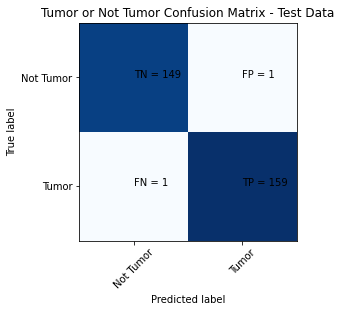

In [ ]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
classNames = ['Not Tumor',"Tumor"]
plt.title('Tumor or Not Tumor Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))

plt.show()

In [ ]:
def detecta(frame):
    img=resize(frame,(IMG_WIDTH,IMG_HEIGHT))
    img=np.expand_dims(img,axis=0)
    if(np.max(img))>1:
        img=img/255.0
    prediction=model.predict(img)
    if prediction>0.5:
        return True
    else:
        return False

In [ ]:
def plot_sample_images(X, y, n=20):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]
        
        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))
        
        i = 1 # current plot        
        for image in n_images:
            
            sub=plt.subplot(rows_n, columns_n, i)
            ax = sub.axis()
            plt.imshow(image[0])
            
            # remove ticks
            plt.tick_params(axis='both', which='both', 
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)
            
            
           
            
            
            
            label_to_str = lambda label: "Yes" if label == 1 else "No"
            if detecta(image[0]) == True:
                if label_to_str =='Yes':
                    rec = plt.Rectangle((0, 0), 260, 260, lw=5,fill=False, color='green',linestyle="solid")
                else:
                    rec = plt.Rectangle((0, 0), 260, 260,lw=5, fill=False, color='red',linestyle="solid") 
            else:
                if label_to_str =='Yes':
                    rec = plt.Rectangle((0, 0), 260, 260, lw=5,fill=False, color='red',linestyle="solid")
                else:
                    rec = plt.Rectangle((0, 0), 260, 260,lw=5, fill=False, color='green',linestyle="solid")
            rec = sub.add_patch(rec)

            rec.set_clip_on(False)
            i += 1
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

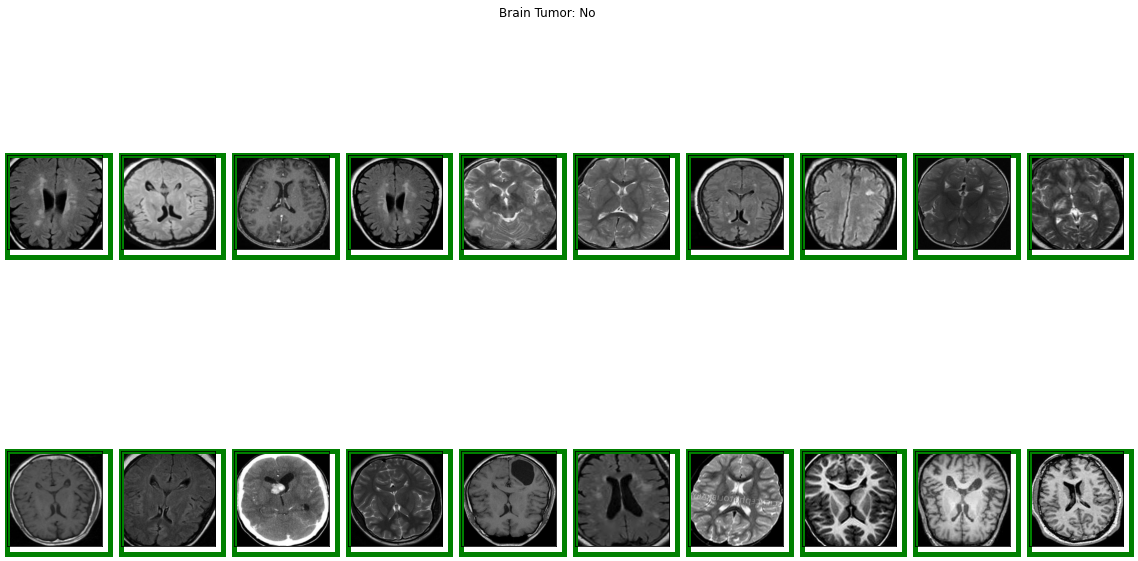

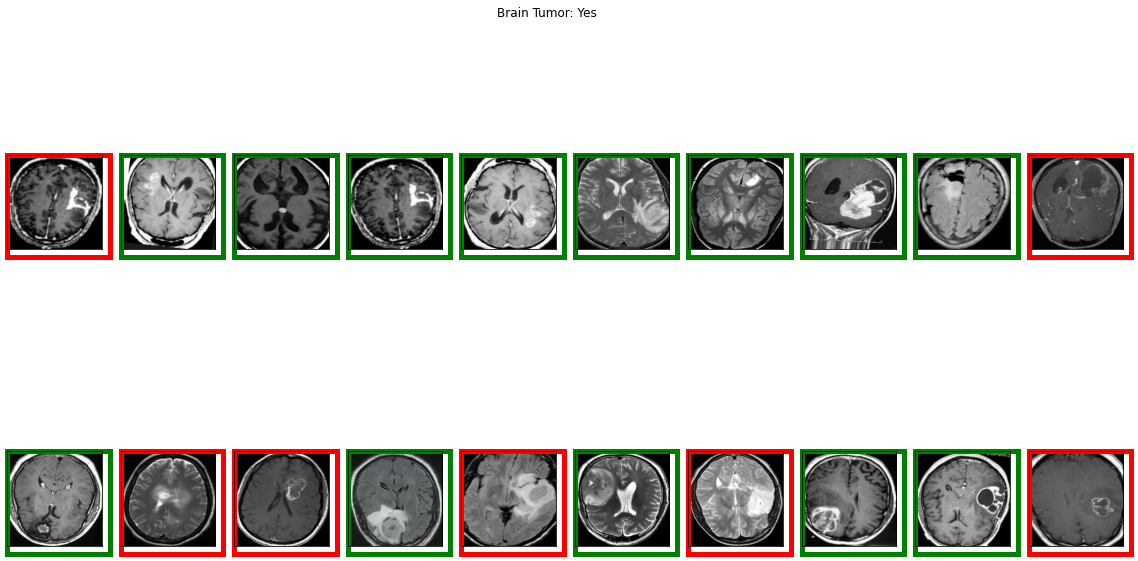

In [ ]:
plot_sample_images(X,y)